In [13]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange
import tensorflow as tf
from nltk.corpus import stopwords
%matplotlib inline


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [18]:
stop = set(stopwords.words('english'))
stop_char = set((',', '.', '!', '|', '&', '-', '_', '(', ')', '[', ']', '<', '>', '{', '}', '/', '"'))

In [65]:
corpus = "output.txt"
f = open(corpus)
lines = f.read().splitlines()
words = collections.Counter()
for line in lines:
    #line = line.split('\t')[3].split(" ")
    line = re.sub(r"http\S+", "", line)    
    line = re.sub(' +',' ',line)
    tokenized_sent =word_tokenize(line)
    list_of_words = [i.lower() for i in tokenized_sent if i.lower() not in stop]
    #line = line.split(" ")
    for word in list_of_words:
        if word not in ['.',',','#']:
            if word in words:
                words[word] = words[word] + 1
            else:
                words[word] = 1
print('Data size', len(words))
#words

Data size 7301


In [66]:
# Step 2: Build the dictionary and replace rare words with UNK token.
vocabulary_size = len(words)


def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(words.most_common(vocabulary_size - 1))
  dictionary = dict()
  #mapping integer to each words
  for word, _ in count:
    dictionary[word] = len(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count += 1
    data.append(index)
  count[0][1] = unk_count
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

Most common words (+UNK) [['UNK', 1], ('nepalearthquake', 7535), ('nepal', 3452), ('earthquake', 1897), ('people', 1134)]
Sample data [2428, 3472, 3473, 919, 3474, 3475, 326, 3476, 920, 3477] ['raining', 'shockened', 'yellow', 'four', 'hanging', 'localized', 'looking', 'attracted', 'electricity', 'unanswered']


In [67]:
data_index = 0

# Step 3: Function to generate a training batch for the skip-gram model.
def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1  # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [skip_window]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  # Backtrack a little bit to avoid skipping words in the end of a batch
  data_index = (data_index + len(data) - span) % len(data)
  return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
  print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

3472 shockened -> 3473 yellow
3472 shockened -> 2428 raining
3473 yellow -> 919 four
3473 yellow -> 3472 shockened
919 four -> 3473 yellow
919 four -> 3474 hanging
3474 hanging -> 919 four
3474 hanging -> 3475 localized


In [68]:
# Step 4: Build and train a skip-gram model.

batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():

  # Input data.
  train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

  # Ops and variables pinned to the CPU because of missing GPU implementation
  with tf.device('/cpu:0'):
    # Look up embeddings for inputs.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    embed = tf.nn.embedding_lookup(embeddings, train_inputs)

    # Construct the variables for the NCE loss
    nce_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

  # Compute the average NCE loss for the batch.
  # tf.nce_loss automatically draws a new sample of the negative labels each
  # time we evaluate the loss.
  loss = tf.reduce_mean(
      tf.nn.nce_loss(weights=nce_weights,
                     biases=nce_biases,
                     labels=train_labels,
                     inputs=embed,
                     num_sampled=num_sampled,
                     num_classes=vocabulary_size))

  # Construct the SGD optimizer using a learning rate of 1.0.
  optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

  # Compute the cosine similarity between minibatch examples and all embeddings.
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
      normalized_embeddings, valid_dataset)
  similarity = tf.matmul(
      valid_embeddings, normalized_embeddings, transpose_b=True)


In [69]:
# Step 5: Begin training.
num_steps = 100001

with tf.Session(graph=graph) as session:
  # We must initialize all variables before we use them.
  tf.initialize_all_variables().run()
  print("Initialized")

  average_loss = 0
  for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch(
        batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
      if step > 0:
        average_loss /= 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print("Average loss at step ", step, ": ", average_loss)
      average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in xrange(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8  # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k + 1]
        log_str = "Nearest to %s:" % valid_word
        for k in xrange(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log_str = "%s %s," % (log_str, close_word)
        print(log_str)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step  0 :  220.804779053
Nearest to victims: feeler, seens, leaders, kid, cnn, consolation, easy-to-carry, 11,
Nearest to families: doctor, manaslu, reassuring, displaced, woman, visibility, electronic, false,
Nearest to family: counted, belong, date, restinpeace, intervention, unclear, quotes, ocean,
Nearest to !: stand-by, month, insular, fellow, relate, fbshare, massively, practical,
Nearest to :: violent, looms, unconditional, -/, rest-in-peace, sarcasms, nz, 2072,
Nearest to dead: jnanpith, human, UNK, constant, safty, consular, moms, jesustweeters,
Nearest to via: jenkinsville, tease, log, backpacking, rasuwa, featuring, francisco, kathamndu,
Nearest to give: inquires, nrcs, spots, indigo, northeast, 23016633, =, jenner,
Nearest to us: recalling, mean, stones, value, charming, population, 23251902, practitioners,
Nearest to lives: kill, boot, jim, administration, immediate, dhararha, undo, bridges,
Nearest to prayfornepal: weekend, yeshi, firstaid, for

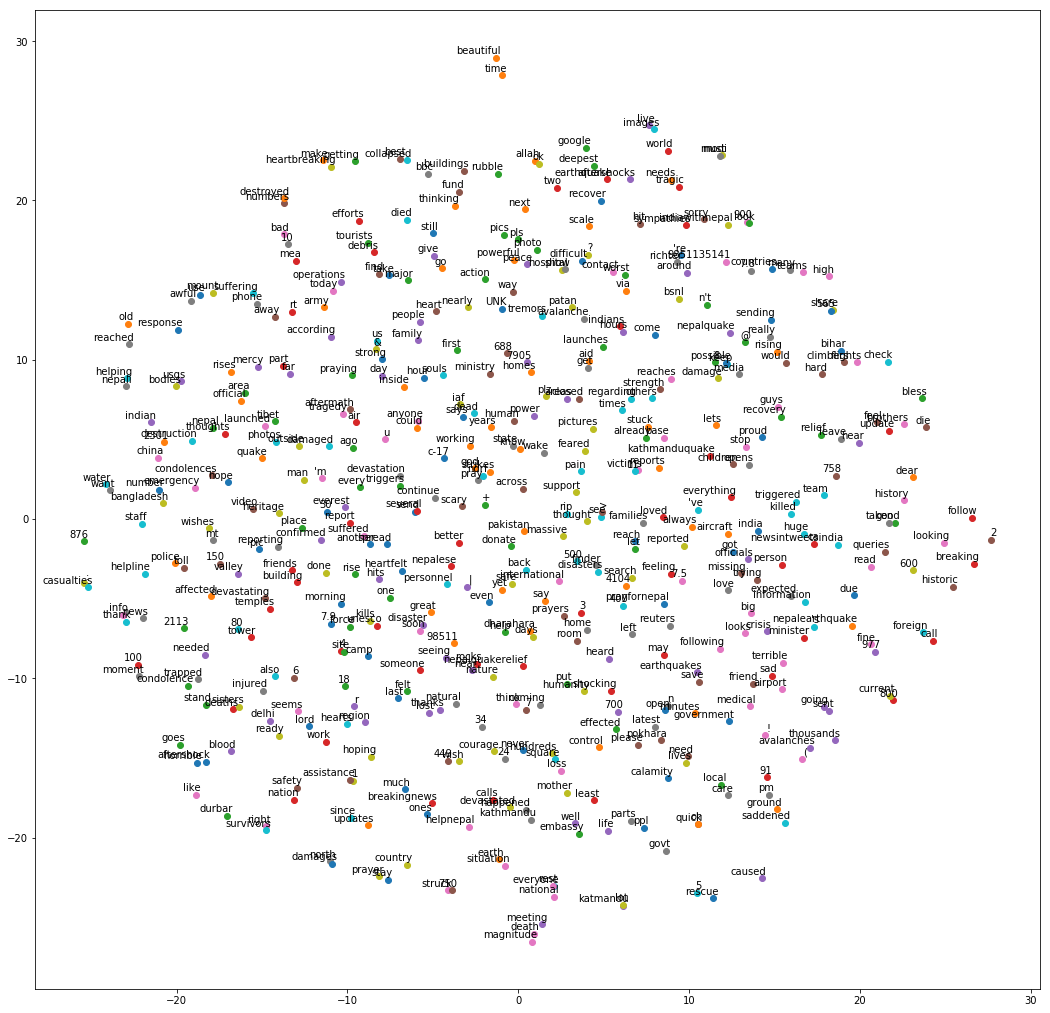

In [70]:
# Step 6: Visualize the embeddings.
def plot_with_labels(low_dim_embs, labels, filename='tsne_new.png'):
  assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
  plt.figure(figsize=(18, 18))  # in inches
  for i, label in enumerate(labels):
    x, y = low_dim_embs[i, :]
    plt.scatter(x, y)
    plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

  plt.savefig(filename)

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [reverse_dictionary[i] for i in xrange(plot_only)]
plot_with_labels(low_dim_embs, labels)


In [1]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
sent = "how are foreigners affected"
tokens = word_tokenize(sent.strip(",.!|&-_()[]<>{}/\"'"))
stop = set(stopwords.words('english'))
stop_char = set((',', '.', '!', '|', '&', '-', '_', '(', ')', '[', ']', '<', '>', '{', '}', '/', '"'))
terms = (set(tokens) - stop) - stop_char
word_list = []
for term in terms:
    for synset in wn.synsets(term):
        word_list.append(synset.lemmas[0].name)
query = ' '.join(word for word in word_list)
query

'affect affect involve feign affect affected affected moved foreigner foreigner'